In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

In [2]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.arima import AutoARIMA

In [3]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

In [4]:
df = pd.read_csv('df.csv' , sep=';', encoding='utf-8', decimal=';')

Для анализа взяты ежемесяzy данные по импорту в РФ в млн $ за период с января 2017 по март 2021. Истоник данных: https://www.fedstat.ru/indicator/41315

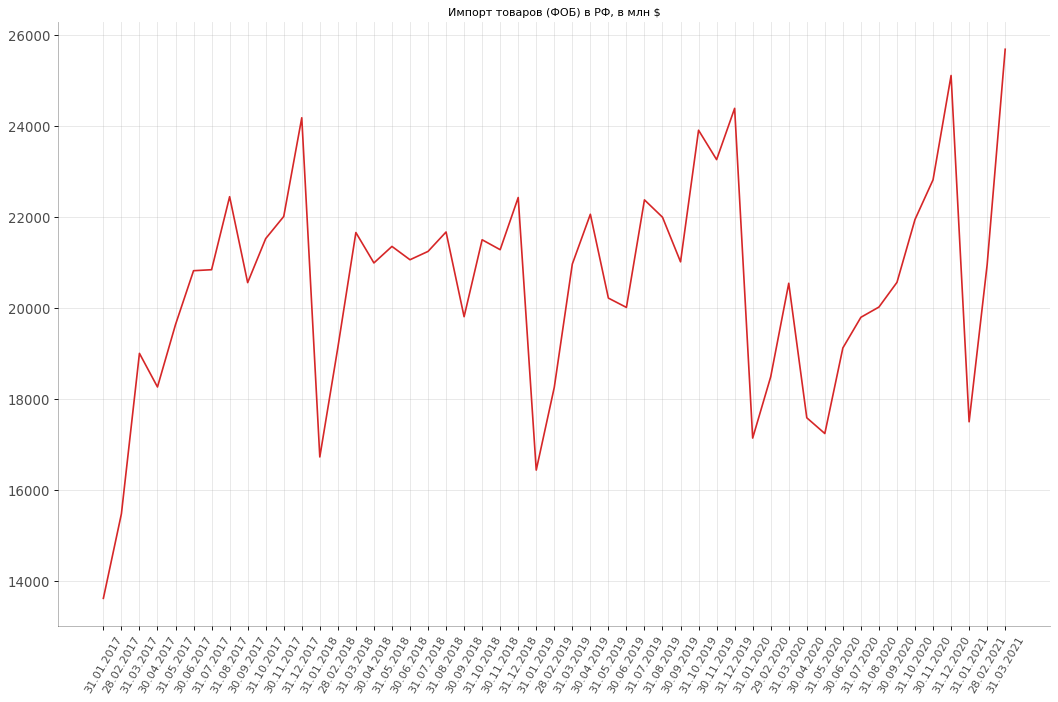

In [5]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot('Date', 'Import', data=df, color='tab:red')

# Decoration
#plt.ylim(50, 750)
#xtick_location = df.index.tolist()[::12]
plt.xticks(rotation=60, fontsize=10, horizontalalignment='center', alpha=.7, label='Дата')
plt.yticks(fontsize=12, alpha=.7, label='Объем импорта')
plt.title("Импорт товаров (ФОБ) в РФ, в млн $", fontsize=10)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

У ряда явно выражена сезоннсоть - в начале каждого года объем резко идет вниз. Какого-то ярко выраженного тренда нет, пир этом ряд не является стационарным, у него есть точки излома, и амплитуда колебаний не растет.

<b><b>ACF and PACF<b><b>

C:\Users\anyak\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


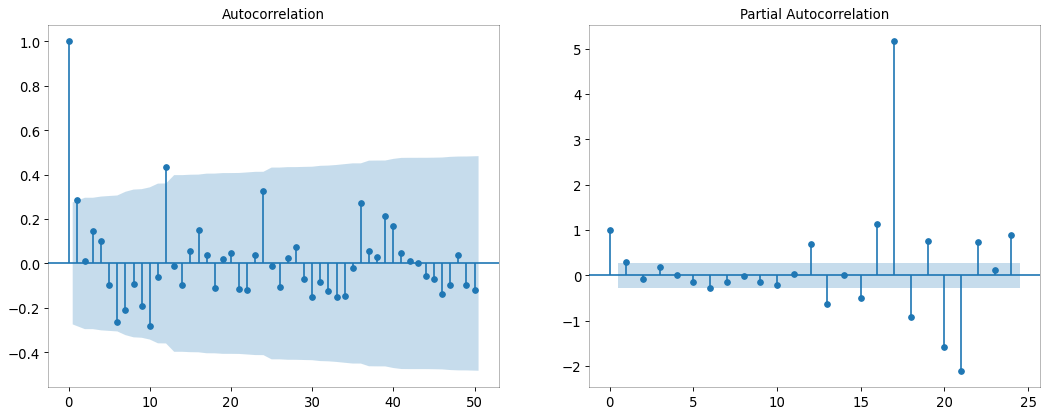

In [6]:
# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(df['Import'], ax=ax1, alpha=0.05, lags=50)
plot_pacf(df['Import'], ax=ax2, alpha=0.05, lags=24)

# Decorate
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [7]:
dates = pd.PeriodIndex(pd.date_range('2017-1-1', '2021-3-31', freq='M').to_pydatetime(), freq='M')
df.set_index(dates, inplace=True)

In [8]:
df = pd.Series(df['Import'])

In [9]:
df = df.asfreq('M')

In [10]:
df = df.astype('float64')

<b>Разделяем взятую выборку на обучающую (январь 2017 - март 2020) и тестовую (апрель 2020 - март 2021) <b>

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Import'>)

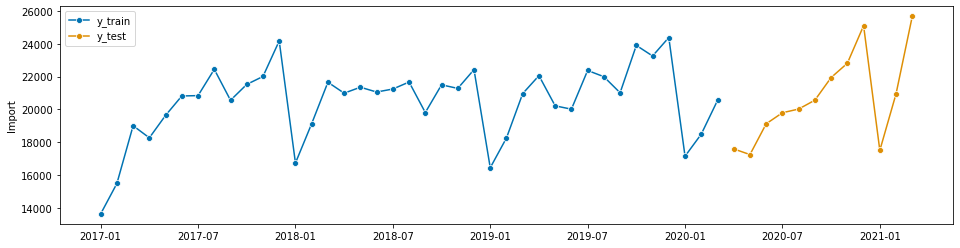

In [12]:
y = df
y_train = df[:-12]
y_test = df[-12:]
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [13]:
fh = np.arange(len(y_test)) + 1 #временной период, на который будет строиться прогноз
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

<b><b>Наивная модель<b><b>

0.10322806421696307

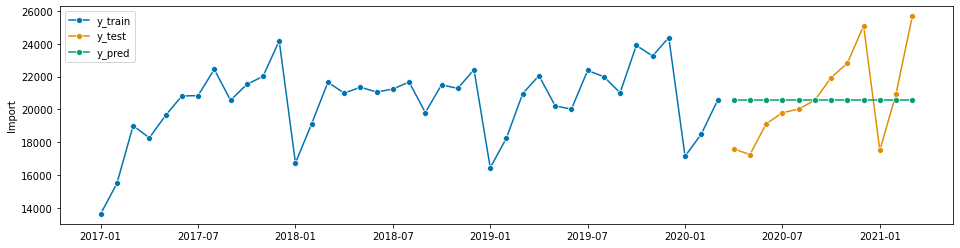

In [14]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

<b><b>Сезонная наивная модель<b><b>

0.09753605815847781

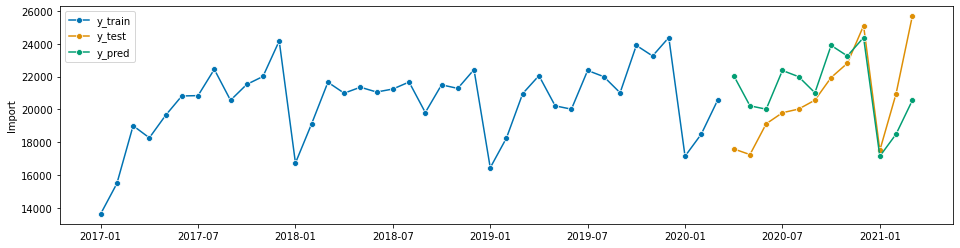

In [15]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

<b><b>SARIMA(1, 1, 1)(1, 0, 0)[12]<b><b>

0.09598529755900113

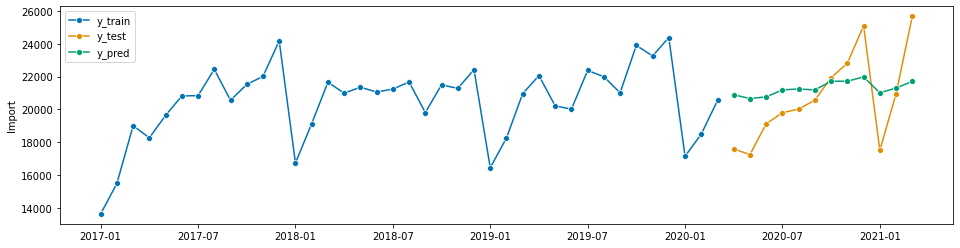

In [16]:
forecaster = ARIMA(
    order=(1, 1, 1), seasonal_order=(1, 0, 0, 12), suppress_warnings=True
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

<b><b>SARIMA с автоматическим подбором<b><b>

0.10453975810430245

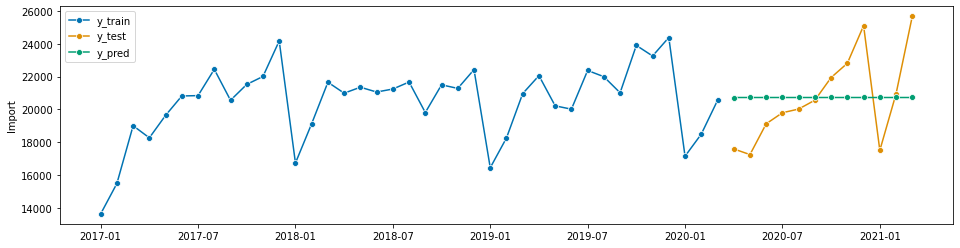

In [17]:
forecaster = AutoARIMA(seasonal="additive", auto=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

<b><b>ETS(AAA)<b><b>

0.10559918912931386

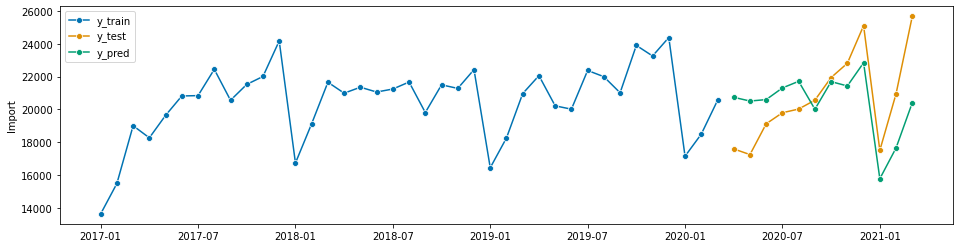

In [18]:
forecaster = ExponentialSmoothing(trend="additive", seasonal="additive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

<b><b>ETS с выбором по AIC<b><b>

0.10263687494867378

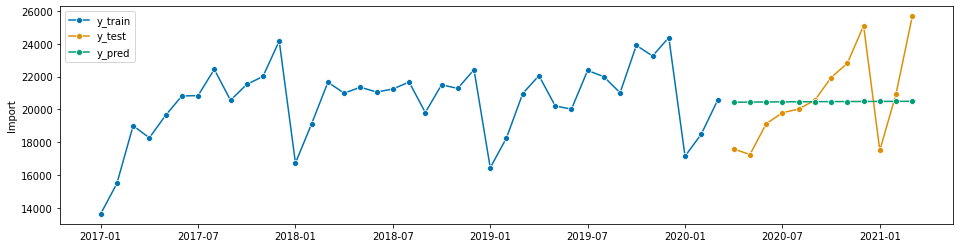

In [19]:
forecaster = AutoETS(auto=True, information_criterion="aic")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

Наименьшее значение ошибки получается у модели SARIMA(1, 1, 1)(1, 0, 0)[12]. Поэтому дальнейший прогноз будет строиться по ней. Теперь все имеющиеся данные по импорту становятся обучающей выборкой, на основе которой будет сделан прогноз на год вперед.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Import'>)

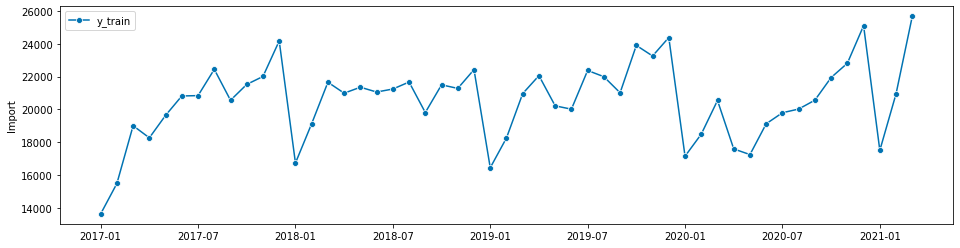

In [20]:
y = df
y_train = df
plot_series(y_train, labels=["y_train"])

0.2650450664854108

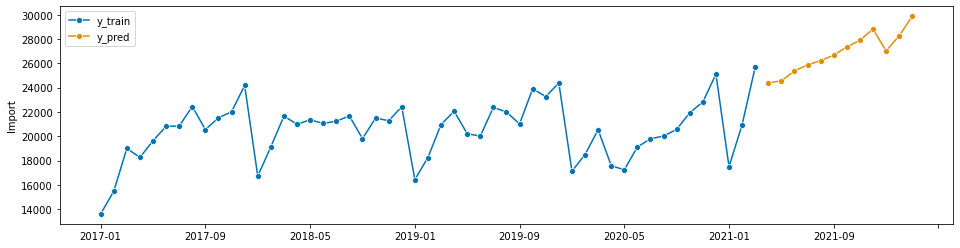

In [21]:
forecaster = ARIMA(
    order=(1, 1, 1), seasonal_order=(1, 0, 0, 12), suppress_warnings=True
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_pred, labels=["y_train", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)